In [1]:
import sqlite3
import pandas as pd
import json
from progressbar import ProgressBar
from fastai.text import *

# Read Lablels

In [2]:
bs = 16

In [3]:
path = './fastai-project/homework/data/NELA19/'
labels_data = pd.read_csv(path + 'labels.csv')

In [4]:
labels_data.head()

,source,aggregated_label,"Pew Research Center, known_by_40%","Pew Research Center, total","Pew Research Center, consistently_liberal","Pew Research Center, mostly_liberal","Pew Research Center, mixed","Pew Research Center, mostly conservative","Pew Research Center, consistently conservative","Wikipedia, is_fake",...,"Allsides, community_agree","Allsides, community_disagree","Allsides, community_label","BuzzFeed, leaning","PolitiFact, Pants on Fire!","PolitiFact, False","PolitiFact, Mostly False","PolitiFact, Half-True","PolitiFact, Mostly True","PolitiFact, True"
0,21stcenturywire,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
1,abcnews,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,NaN,...,8964.0,6949.0,somewhat agree,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,activistpost,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
3,addictinginfo,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,left,NaN,NaN,NaN,NaN,NaN,NaN
4,adobochronicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
with open(path + 'source-metadata.json') as file:
    metadata = (json.loads(file.read()))

In [6]:
for source in metadata.keys():
    labels_data.loc[labels_data.source == source, 'n_articles'] = metadata[source]['articles']

In [7]:
cols = ['source', 'n_articles', 'aggregated_label', 'Media Bias / Fact Check, label']
labels_data[cols].head(10)

,source,n_articles,aggregated_label,"Media Bias / Fact Check, label"
0,21stcenturywire,791.0,2.0,conspiracy_pseudoscience
1,abcnews,2861.0,0.0,left_center_bias
2,activistpost,2780.0,2.0,conspiracy_pseudoscience
3,addictinginfo,12.0,1.0,left_bias
4,adobochronicles,417.0,NaN,satire
5,ageofautism,646.0,2.0,conspiracy_pseudoscience
6,airwars,16.0,0.0,least_biased
7,aljazeera,11611.0,0.0,left_center_bias
8,americablognews,104.0,0.0,left_bias
9,anonnews,508.0,NaN,NaN


# Read Data

In [8]:
# Execute query and load results into pandas dataframe
def execute_query_pandas(path, query):
    conn = sqlite3.connect(path)
    df = pd.read_sql_query(query, conn)
    return df

In [9]:
file = path + 'nela-eng-2019.db'
#query= ''' SELECT * FROM newsdata WHERE strftime('%m', date) in ('01')'''
query= ''' SELECT * FROM newsdata '''
#query = ''' SELECT * FROM newsdata WHERE source='21stcenturywire' '''

data = execute_query_pandas(file, query)

In [10]:
for source in labels_data['source']:
    data.loc[data.source == source, 'label'] = labels_data.loc[labels_data.source == source, 'aggregated_label'].values[0]
    data.loc[data.source == source, 'bias'] = labels_data.loc[labels_data.source == source, 'Media Bias / Fact Check, label'].values[0]

bias_list = ['left_bias', 'left_center_bias', 'right_center_bias', 'right_bias', 'questionable_source']
data = data.loc[data['bias'].isin(bias_list)].dropna(subset = ['label', 'bias'], how='any')

In [11]:
data.sample(3)

,id,date,source,title,content,author,url,published,published_utc,collection_utc,label,bias
669978,theguardianuk--2019-05-20--Children join Extin...,2019-05-20,theguardianuk,Children join Extinction Rebellion weedkiller ...,The Hackney families branch of Extinction Rebe...,,https://www.theguardian.com/environment/galler...,2019-05-20 13:19:23+00:00,1558372763,1567540439,0.0,left_center_bias
829924,theindependent--2019-03-09--Barbie at 60 Beyon...,2019-03-09,theindependent,Barbie at 60: Beyond role play what is the poi...,Happy 60th birthday. You don’t look a day over...,Andy Martin,https://www.independent.co.uk/news/long_reads/...,2019-03-09 11:10:00+00:00,1552147800,1567546809,0.0,left_center_bias
306272,sputnik--2019-05-03--A Complete Failure Venezu...,2019-05-03,sputnik,‘A Complete Failure’: Venezuelan Coup Attempts...,Guaido has claimed since January 23 to be Vene...,,https://sputniknews.com/analysis/2019050310746...,2019-05-03 00:46:39+00:00,1556858799,1567541328,0.0,right_center_bias


# Build Language Model

We tokenize and build the vocabulary

In [32]:
data_lm = (TextList.from_df(data, cols='content')
                                .split_by_rand_pct(0.1)
                                #.label_from_df(cols='label')
                                .label_for_lm() 
                                .databunch(bs=bs))

In [33]:
data_lm.save(path + 'data_lm.pkl')

In [94]:
#data_lm.show_batch()
#data_lm.vocab.itos[30:40]
#data_lm.train_ds[1][0]
#data_lm.train_ds[0][0].data[:10]

In [12]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [13]:
data_lm.show_batch()

idx,text
0,"to continue . \n \n xxmaj but in a sharp reversal of its stance just one month ago , the xxmaj fed did not say it expected to keep raising interest rates . xxmaj instead , the statement said the xxmaj fed would be “ patient ” in evaluating the health of the economy . xxmaj and it indicated that the xxmaj fed stood ready either to increase or"
1,"the investigation into xxmaj alex xxmaj salmond will discourage sexual harassment victims from coming forward , experts and opposition politicians warned last night . \n \n xxmaj campaigners said the message sent out by the bungling of the high - profile probe could make women who had suffered abuse think twice about lodging complaints over their treatment . \n \n xxmaj the xxmaj record told last year how"
2,"” to describe people he sees as insufficiently xxmaj american . “ xxmaj globalist — one of xxmaj trump ’s favorite xxunk — implies that someone is not of - this - nation , they ’re not tied here , their loyalty is not to * us * of this country but to * each other * internationally , ” xxmaj xxunk wrote . “ xxmaj the idea the"
3,"spiraling out of control , with the xxmaj border xxmaj patrol announcing that the biggest single - day surges in more than a decade have occurred twice this week alone . \n \n xxmaj customs and xxmaj border xxmaj patrol ( xxup cbp ) shared the stunning details on xxmaj twitter just hours after xxup cbp chief xxmaj kevin mcaleenan declared the xxup u.s. has reached the “ breaking"
4,". \n \n xxmaj john xxmaj xxunk , who has been active in restoring the waterways since 1961 and who chairs the xxmaj montgomery xxmaj canal xxmaj partnership , said that a 1970 conference in xxmaj oxford on the urban future of canals “ was instrumental in turning the tide with town planners and highway engineers ” . \n \n xxmaj he said : “ xxmaj we need"


In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3, 
                                metrics=[accuracy, Perplexity()])

In [16]:
TEXT = "The new book"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The new book by Jonathan - Miller , known as The Big Name , is based on a New Yorker article . 
 
  The published piece says that the two men had a story
The new book is an issue on a number of recent social media appearances . It 's a early focus on the issue of the United States Constitution 's current Congress . The Democratic Party


In [46]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 8.32E-03


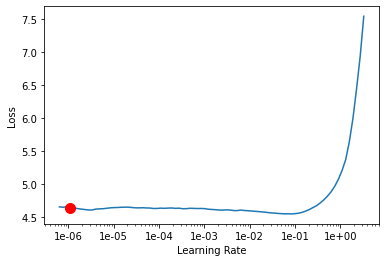

In [51]:
learn.recorder.plot(suggestion=True)

In [58]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time


KeyboardInterrupt: 

In [61]:
learn.save('1epoch')

In [18]:
learn.load('1epoch');

In [63]:
learn.unfreeze()

In [64]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,perplexity,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-03
Min loss divided by 10: 6.31E-08


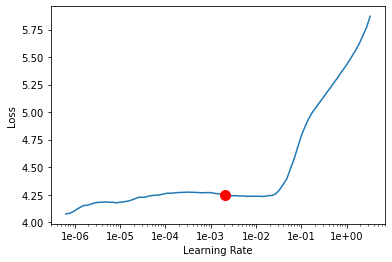

In [65]:
learn.recorder.plot(suggestion=True)

In [66]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.554946,4.450575,0.314286,85.676186,6:20:35


In [68]:
learn.save('finetuned')

In [20]:
TEXT = "The new book"
N_WORDS = 100
N_SENTENCES = 1
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The new book is a sort of English - language book , authors : The New York Times   published the story of a man who has had a “ Jewish ” history , and a new book by David Flights , with a new book called The Man Who Dies Out , which has been published on   France Global . 
 
  The book , titled “ The First Time in American History , ” includes a sentence of  


In [19]:
learn.load('finetuned');

In [21]:
learn.save_encoder('finetuned_enc')

# Bias Classifier

In [ ]:
data_bb = (TextList.from_df(data, cols=['title','content'],  vocab=data_lm.vocab)
                                .split_by_rand_pct(0.1)
                                .label_from_df(cols='bias')
                                .databunch(bs=bs))

In [ ]:
data_bb.save(path + 'data_bb.pkl')

In [6]:
data_bb = load_data(path, 'data_bb.pkl', bs=bs)

In [7]:
data_bb.show_batch()

text,target
"xxbos xxmaj archive : ' xxmaj this xxmaj week ' xxmaj transcripts xxmaj below are links to transcripts of previous "" xxmaj this xxmaj week with xxmaj george xxmaj stephanopoulos "" episodes . xxmaj head to our homepage for our more recent show transcripts . \n \n xxmaj you can see full video of past programs xxup here . \n \n xxmaj like "" xxmaj this xxmaj week",left_center_bias
"xxbos xxmaj when xxmaj they xxmaj want xxmaj war , xxmaj india and xxmaj pakistan xxmaj will xxmaj always xxmaj have xxmaj kashmir xxmaj when this series was first published in xxmaj the xxmaj daily xxmaj beast last xxmaj december , i had no idea that xxmaj kashmir was about to explode — quite literally — into the headlines again . \n \n xxmaj there had been numerous developments",left_bias
xxbos xxmaj lt . xxmaj gen. xxmaj ben xxmaj hodges on xxmaj iraq : ' i xxmaj never xxmaj dreamed xxmaj that xxmaj we xxmaj would xxmaj still xxmaj be xxmaj involved ' xxmaj sputnik : xxmaj what did you know about the situation in xxmaj iraq before you went there and what did you know and thought about xxmaj saddam xxmaj hussein ? xxmaj what,right_center_bias
"xxbos xxmaj the xxmaj french xxmaj economist xxmaj who xxmaj helped xxmaj invent xxmaj elizabeth xxmaj warren ’s xxmaj wealth xxmaj tax xxmaj to trace the progress of the wealth tax from a fringe academic idea to the center of the xxmaj democratic xxmaj presidential primary , it is helpful to begin a bit off - center . xxmaj on xxmaj september 15 , 2008 , the day that xxmaj",left_bias
xxbos xxmaj uganda v xxmaj egypt : xxmaj african xxmaj cup of xxmaj nations – live ! [ xxunk xxup edt xxunk ] ( / football / live / 2019 / jun / 30 / uganda - v - egypt - african - cup - of- \n nations - live?page = with : xxunk # block- \n xxunk ) \n \n # # xxmaj half - time,left_center_bias


In [8]:
learn = text_classifier_learner(data_bb, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('finetuned_enc');

In [25]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.09E-02


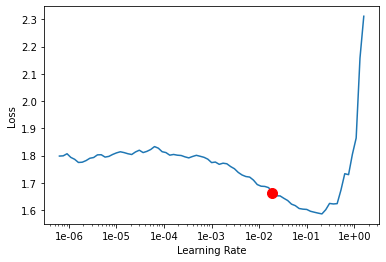

In [27]:
learn.recorder.plot(suggestion=True)

In [6]:
learn.fit_one_cycle(1, 2e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [7]:
learn.save('bias_1epoch')

In [9]:
learn.load('bias_1epoch');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('bias_f_1epoch')

In [ ]:
learn.load('bias_f_1epoch');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('bias_f_2epoch')

In [ ]:
learn.predict("I really loved that movie, it was awesome!")